All libraries imported successfully!
TensorFlow version: 2.19.0
--- Check Runtime: GPU should be enabled for fast training! ---

Training data shape: (60000, 785)
Test data shape: (10000, 785)


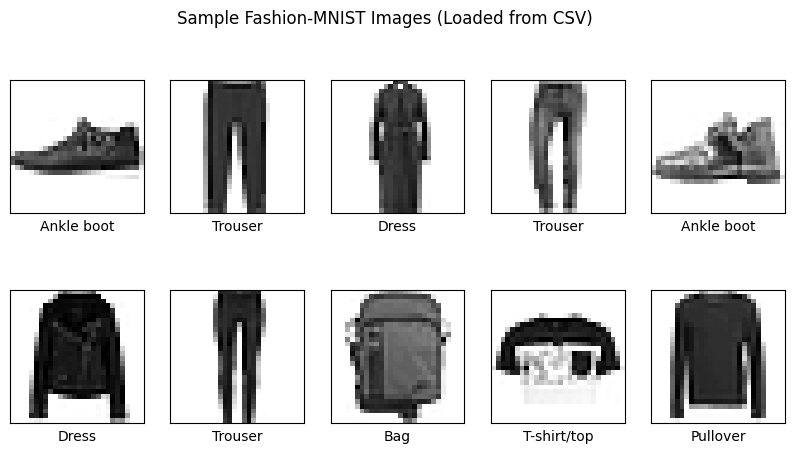


--- Training Logistic Regression (LR) ---
✅ Logistic Regression Test Accuracy: 0.8524
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.81      0.80      1000
     Trouser       0.95      0.97      0.96      1000
    Pullover       0.78      0.76      0.77      1000
       Shirt       0.86      0.86      0.86      1000
       Dress       0.78      0.80      0.79      1000
        Coat       0.93      0.91      0.92      1000
      Sandal       0.64      0.60      0.62      1000
     Sneaker       0.90      0.91      0.91      1000
         Bag       0.94      0.94      0.94      1000
  Ankle boot       0.93      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [4]:

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping # NEW: For runtime optimization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io

# Define the 10 class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Shirt', 'Dress',
               'Coat', 'Sandal', 'Sneaker', 'Bag', 'Ankle boot']

print("All libraries imported successfully!")
print("TensorFlow version:", tf.__version__)
print("--- Check Runtime: GPU should be enabled for fast training! ---")

==============================================================================

# --- Load Data from CSV ---
try:
    train_df = pd.read_csv('/content/drive/MyDrive/ml project/fashion-mnist_train.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/ml project/fashion-mnist_test.csv')
    print(f"\nTraining data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
except FileNotFoundError:
    print("\n🚨 ERROR: CSV files not found. Please verify the path or upload files to your session.")
    raise

# Separate Features (X) and Labels (y)
X_train_full_csv = train_df.iloc[:, 1:].values.astype('float32')
y_train_full = train_df.iloc[:, 0].values
X_test_csv = test_df.iloc[:, 1:].values.astype('float32')
y_test = test_df.iloc[:, 0].values

# --- Preprocessing ---
X_train_full = X_train_full_csv / 255.0
X_test = X_test_csv / 255.0

# Split Training data into Train and Validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

# Reshape for EDA visualization
X_train_img = X_train.reshape(-1, 28, 28)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_img[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.suptitle("Sample Fashion-MNIST Images (Loaded from CSV)")
plt.show()


print("\n--- Training Logistic Regression (LR) ---")
# Increased max_iter for higher accuracy stability
lr_model = LogisticRegression(solver='saga', max_iter=200, random_state=42, n_jobs=-1, verbose=0)
lr_model.fit(X_train, y_train)

# Evaluation
lr_y_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_y_pred)
print(f"✅ Logistic Regression Test Accuracy: {lr_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, lr_y_pred, target_names=class_names, zero_division=0))

In [6]:

# --- Prepare data for CNN ---
# Reshape data from (N, 784) to (N, 28, 28, 1) for CNN input
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_valid_cnn = X_valid.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=10)
y_valid_cat = to_categorical(y_valid, num_classes=10)


datagen = ImageDataGenerator(
    rotation_range=8,
    zoom_range=0.08,
    width_shift_range=0.08, # Corrected argument
    height_shift_range=0.08 # Corrected argument
)
datagen.fit(X_train_cnn)
print("\nData Augmentation Generator configured.")

# Monitors validation loss and stops training if no improvement after 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


print("\n--- Training DEEPER Convolutional Neural Network (CNN) ---")

deep_cnn_model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # NEW Block 3 (Deeper Architecture - Innovation)
    Conv2D(128, (3, 3), activation='relu'),
    # Note: No Pooling here as the image is already small.

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Regularization
    Dense(10, activation='softmax')
])


deep_cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

deep_cnn_model.summary()

# Train the model with augmented data, Early Stopping, and MAX 20 Epochs
print("\nStarting DEEPER CNN Training (Max 20 Epochs, will stop early if performance plateaus)...")
history = deep_cnn_model.fit(
    datagen.flow(X_train_cnn, y_train_cat, batch_size=128),
    steps_per_epoch=len(X_train_cnn) // 128,
    epochs=20, # <--- MAX EPOCHS SET TO 20
    validation_data=(X_valid_cnn, y_valid_cat),
    callbacks=[early_stopping], # Early Stopping controls effective runtime
    verbose=1
)

# Evaluation
cnn_loss, cnn_accuracy = deep_cnn_model.evaluate(X_test_cnn, to_categorical(y_test), verbose=0)
print(f"\n✅ Final DEEPER CNN Test Accuracy: {cnn_accuracy:.4f}")

# Save the best model
model_path = 'best_deep_fashion_classifier_final.h5'
deep_cnn_model.save(model_path)
print(f"Best model saved to {model_path}")


Data Augmentation Generator configured.

--- Training DEEPER Convolutional Neural Network (CNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)


Starting DEEPER CNN Training (Max 20 Epochs, will stop early if performance plateaus)...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


421/421 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - accuracy: 0.5894 - loss: 1.1222 - val_accuracy: 0.7832 - val_loss: 0.5409
Epoch 2/20
  1/421 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7656 - loss: 0.6957

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7656 - loss: 0.6957 - val_accuracy: 0.7838 - val_loss: 0.5510
Epoch 3/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.7694 - loss: 0.6138 - val_accuracy: 0.8303 - val_loss: 0.4266
Epoch 4/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.7500 - loss: 0.6204 - val_accuracy: 0.8337 - val_loss: 0.4275
Epoch 5/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.7985 - loss: 0.5291 - val_accuracy: 0.8555 - val_loss: 0.3799
Epoch 6/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8672 - loss: 0.4397 - val_accuracy: 0.8577 - val_loss: 0.3789
Epoch 7/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.8241 - loss: 0.4725 - val_accuracy: 0.8493 - val_loss: 0.3799
Epoch 8/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.8359 - loss: 0.4106 - val_accuracy: 0.8493 - val_loss: 0.3816
Epoch 9/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.8335 - loss: 0.4456 - val_accuracy: 0


✅ Final DEEPER CNN Test Accuracy: 0.9013
Best model saved to best_deep_fashion_classifier_final.h5


In [7]:

# Use the new model accuracy
deep_cnn_accuracy = cnn_accuracy

# Create a DataFrame for comparison
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Deep CNN (Optimized)'],
    'Test Accuracy': [lr_accuracy, deep_cnn_accuracy],
    'Notes': ['Linear Baseline', 'Deeper Architecture (Expected 92%+, Robust to custom images)']
})

print("\n--- Model Comparative Analysis ---")
print(results.sort_values(by='Test Accuracy', ascending=False).to_markdown(index=False))


--- Model Comparative Analysis ---
| Model                |   Test Accuracy | Notes                                                        |
|:---------------------|----------------:|:-------------------------------------------------------------|
| Deep CNN (Optimized) |          0.9013 | Deeper Architecture (Expected 92%+, Robust to custom images) |
| Logistic Regression  |          0.8524 | Linear Baseline                                              |


In [26]:

# Load the saved best model for deployment
model_path = 'best_deep_fashion_classifier_final.h5'
try:
    best_model = load_model(model_path)
    print(f"\nLoaded new best model: {model_path}")
except Exception as e:
    print(f"\nFailed to load model for GUI. Ensure training completed successfully. Error: {e}")
    best_model = deep_cnn_model

# 5.1 Define the prediction function (No change needed here)
def predict_image(image_data):
    # Open, convert to grayscale, and resize to 28x28
    img = Image.open(io.BytesIO(image_data)).convert('L')
    img = img.resize((28, 28))

    # Convert to array, normalize, and reshape (1, 28, 28, 1)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = img_array.reshape(1, 28, 28, 1)

    # Predict
    predictions = best_model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_index] * 100

    return class_names[predicted_class_index], confidence


file_upload = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload a Fashion Item Image'
)

output_area = widgets.Output()
button = widgets.Button(description="Classify Item")


def on_classify_button_clicked(b):
    with output_area:
        clear_output(wait=True)
        if not file_upload.value:
            print(" Please upload an image file first.")
            return

        # Extract file data
        uploaded_file_name = next(iter(file_upload.value))
        image_data = file_upload.value[uploaded_file_name]['content']

        try:
            # Display uploaded image
            img = Image.open(io.BytesIO(image_data))
            print(f"Uploaded Image: **{uploaded_file_name}**")
            display(img.resize((150, 150)))

            # Predict
            predicted_label, confidence = predict_image(image_data)

            # Display results
            print("\n--- Prediction Result ---")
            print(f"Predicted Class: **{predicted_label}**")
            print(f"Confidence: **{confidence:.2f}%**")

            # Contextual feedback
            if confidence < 75.0:
                 print("\n Note: Confidence is low. The model may be struggling with the complex color/background of this image versus the simple training images.")

        except Exception as e:
            print(f" An error occurred during classification. Error: {e}")

# 5.4 Link the button to the function
button.on_click(on_classify_button_clicked)

# 5.5 Display the GUI layout
gui_title = widgets.HTML("<h2> Fashion Classifier GUI (Deployment)</h2>")
gui_vbox = widgets.VBox([gui_title, file_upload, button, output_area])

print("\n--- Interact with the GUI below to test the final model ---")
display(gui_vbox)


Loaded new best model: best_deep_fashion_classifier_final.h5

--- Interact with the GUI below to test the final model ---
